## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
# Подключим необходимые библиотеки для проекта

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

/Users/mordovets.i/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
# Откроем файл с данными

df = pd.read_csv('/Users/mordovets.i/Desktop/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Выведем первые 5 строк

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Проверим наличие пустых значений

df.isna().sum()

num_orders    0
dtype: int64

In [5]:
# Проверим упорядочен ли наш index

print(df.index.is_monotonic)

True


# 2. Анализ

In [6]:
# Проведем ресемплирование по 1 часу, неделе и месяцу

monthly_stat= df.resample('1M').sum()
weekly_stat = df.resample('1W').sum()
hourly_stat = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

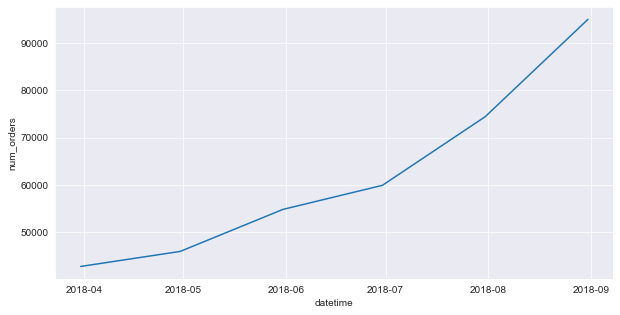

In [7]:
# Посмотрим на статистику заказов в разбивке по месяцам

sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders'])

Видим стабильный рост от месяца к месяцу.

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

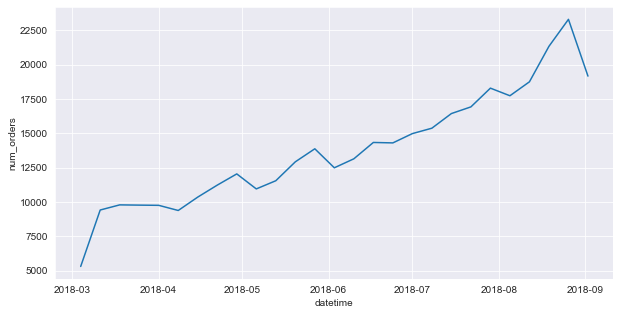

In [8]:
# Посмотрим на статистику заказов в разбивке по неделям

sns.lineplot(x=weekly_stat.index,y=weekly_stat['num_orders'])

При более детальном рассмотрении видно, что количество заказов от недели к недели то уменьшается, то увеличивается, однако виден тренд на увеличение в среднем.

<AxesSubplot:xlabel='datetime'>

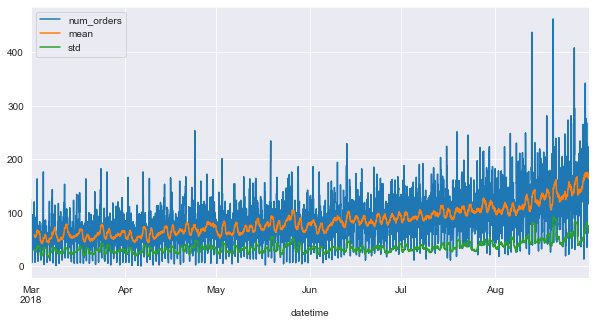

In [9]:
# Посмотрим на скользящее среднее и стандартное отклонение

hourly_stat['mean'] = hourly_stat['num_orders'].rolling(25).mean()
hourly_stat['std'] = hourly_stat['num_orders'].rolling(25).std()
hourly_stat.plot()

Да, так и есть. При ресемплировании по часу видно, что временной ряд нестационарный, поскольку среднее значение увеличивается со временем, то есть при локальных колебаниях среднее количество заказов медленно, но верно растет, что приятно.


- На графике **"Тренд"** можно увидеть, что количество заказов постепенно увеличивается;
- На графике **"Сезонность в течение недели"** видно, как количество заказов по выходным меньше чем в другие дни;
- На графике **"Сезонность в течение дня"** количество заказов к утру намного меньше, чем в другое время.

# 3. Обучение

In [12]:
# Выполним ресемплирование по одному часу

df = df.resample('1H').sum()

#Создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [13]:
df.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.320198
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,30.263125
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.888889
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.555556
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.888889
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.111111
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,223.111111


In [14]:
# Разделим нашу таблилцу на обучающую и тестовую выборки

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [15]:
# Определим признаки и целевой признак у обучающей и тестовой выборок

X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [16]:
# Проверим правильно ли расположены временные даннные, нельзя допустить в обучающую выборку данные из будущего

display(train.head(3))
display(test.head(3))

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,9,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,3,10,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,3,11,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222


,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,103.000000
2018-08-13 15:00:00,175,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,105.111111
2018-08-13 16:00:00,144,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,117.222222


In [17]:
# Размеры обучающей и тестовой выборки

print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3965 объектов, 12 признаков
Размер тестовой выборки: 442 объектов, 12 признаков


### LightGBM

In [18]:
model = lgb.LGBMRegressor()

param_search =  {
              'max_depth' : [5, 10],
              'learning_rate' : [0.05, 0.1, 0.2],
              'n_estimators'    : [50, 100, 500]
                 }

tscv = TimeSeriesSplit(n_splits=5)

gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, verbose=2, n_jobs=-1)

gsearch.fit(X, y)

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          gsearch.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          gsearch.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          gsearch.best_params_)
    
print("\n ========================================================")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.05, max_depth=10)

 The best score across ALL searched params:
 0.4596003976987205

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}



In [19]:
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())

In [20]:
gbm_predictions = gsearch.predict(X_test)
print('RMSE:', round(rmse(gbm_predictions,y_test), 2))

RMSE: 46.04


### CatBoost

In [21]:
model = CatBoostRegressor()

param_search =  {
              'depth'         : [4, 8],
              'learning_rate' : [0.1, 0.2, 0.5],
              'iterations'    : [100, 200, 500]
                 }

tscv = TimeSeriesSplit(n_splits=5)

gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, verbose=2, n_jobs=-1)

gsearch.fit(X, y)

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
    
print("\n The best estimator across ALL searched params:\n",
          gsearch.best_estimator_)
    
print("\n The best score across ALL searched params:\n",
          gsearch.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          gsearch.best_params_)
    
print("\n ========================================================")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0:	learn: 36.8578264	total: 64.3ms	remaining: 32.1s
1:	learn: 35.3160267	total: 70.8ms	remaining: 17.6s
2:	learn: 33.8160204	total: 76.6ms	remaining: 12.7s
3:	learn: 32.6129211	total: 81.9ms	remaining: 10.2s
4:	learn: 31.5398685	total: 87.2ms	remaining: 8.63s
5:	learn: 30.5664255	total: 93ms	remaining: 7.66s
6:	learn: 29.7343669	total: 98.4ms	remaining: 6.93s
7:	learn: 28.9714144	total: 103ms	remaining: 6.36s
8:	learn: 28.2896713	total: 109ms	remaining: 5.94s
9:	learn: 27.6622853	total: 114ms	remaining: 5.59s
10:	learn: 27.2251856	total: 119ms	remaining: 5.31s
11:	learn: 26.7575262	total: 125ms	remaining: 5.07s
12:	learn: 26.3048899	total: 130ms	remaining: 4.88s
13:	learn: 25.8568826	total: 135ms	remaining: 4.7s
14:	learn: 25.4906768	total: 141ms	remaining: 4.55s
15:	learn: 25.2258309	total: 146ms	remaining: 4.42s
16:	learn: 24.9477571	total: 152ms	remaining: 4.32s
17:	learn: 24.7616221	total: 157ms	remaining: 4.21s
18:	learn

156:	learn: 16.6793697	total: 1.53s	remaining: 3.35s
157:	learn: 16.6214591	total: 1.56s	remaining: 3.38s
158:	learn: 16.5867703	total: 1.58s	remaining: 3.39s
159:	learn: 16.5408207	total: 1.6s	remaining: 3.39s
160:	learn: 16.5166064	total: 1.61s	remaining: 3.39s
161:	learn: 16.4518116	total: 1.62s	remaining: 3.38s
162:	learn: 16.3903411	total: 1.64s	remaining: 3.4s
163:	learn: 16.3341712	total: 1.67s	remaining: 3.43s
164:	learn: 16.2966250	total: 1.69s	remaining: 3.43s
165:	learn: 16.2924091	total: 1.7s	remaining: 3.42s
166:	learn: 16.2420275	total: 1.71s	remaining: 3.4s
167:	learn: 16.1836967	total: 1.72s	remaining: 3.39s
168:	learn: 16.1554833	total: 1.73s	remaining: 3.38s
169:	learn: 16.1238814	total: 1.74s	remaining: 3.38s
170:	learn: 16.1141678	total: 1.75s	remaining: 3.37s
171:	learn: 16.0716863	total: 1.76s	remaining: 3.35s
172:	learn: 16.0425203	total: 1.77s	remaining: 3.35s
173:	learn: 16.0412393	total: 1.78s	remaining: 3.33s
174:	learn: 16.0399770	total: 1.79s	remaining: 3.3

318:	learn: 12.4365047	total: 2.71s	remaining: 1.54s
319:	learn: 12.4109774	total: 2.72s	remaining: 1.53s
320:	learn: 12.3967963	total: 2.72s	remaining: 1.52s
321:	learn: 12.3762074	total: 2.73s	remaining: 1.51s
322:	learn: 12.3580769	total: 2.73s	remaining: 1.5s
323:	learn: 12.3400839	total: 2.74s	remaining: 1.49s
324:	learn: 12.3143226	total: 2.74s	remaining: 1.48s
325:	learn: 12.2991104	total: 2.75s	remaining: 1.47s
326:	learn: 12.2769580	total: 2.75s	remaining: 1.46s
327:	learn: 12.2426109	total: 2.76s	remaining: 1.45s
328:	learn: 12.2382477	total: 2.76s	remaining: 1.44s
329:	learn: 12.2275450	total: 2.77s	remaining: 1.43s
330:	learn: 12.2125294	total: 2.77s	remaining: 1.42s
331:	learn: 12.2016101	total: 2.78s	remaining: 1.41s
332:	learn: 12.1874691	total: 2.78s	remaining: 1.4s
333:	learn: 12.1727405	total: 2.79s	remaining: 1.39s
334:	learn: 12.1365155	total: 2.79s	remaining: 1.38s
335:	learn: 12.1155969	total: 2.8s	remaining: 1.37s
336:	learn: 12.0936165	total: 2.81s	remaining: 1.

492:	learn: 9.5331145	total: 3.68s	remaining: 52.3ms
493:	learn: 9.5194892	total: 3.69s	remaining: 44.8ms
494:	learn: 9.5096399	total: 3.69s	remaining: 37.3ms
495:	learn: 9.4990268	total: 3.7s	remaining: 29.8ms
496:	learn: 9.4928793	total: 3.7s	remaining: 22.4ms
497:	learn: 9.4645573	total: 3.71s	remaining: 14.9ms
498:	learn: 9.4498559	total: 3.71s	remaining: 7.44ms
499:	learn: 9.4483760	total: 3.72s	remaining: 0us

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.4524123491499079

 The best parameters across ALL searched params:
 {'depth': 8, 'iterations': 500, 'learning_rate': 0.1}



In [22]:
cbr_predictions = gsearch.predict(X_test)
print('RMSE:', round(rmse(cbr_predictions,y_test), 2))

RMSE: 45.08


### Linear Regression

In [23]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE:', round(rmse(lr_predictions,y_test), 2))

RMSE: 54.09


После подбора гиперпараметров лучше всего себя показала модель CatBoostRegressor. Для подбора была использована кросс-валидация и механизм Time series split для разделение временного ряда на тренировочные данные и валидационные.

# 4. Тестирование

In [24]:
model = CatBoostRegressor(
                          iterations=200,
                          depth=4,
                          learning_rate=0.1
)

model.fit(X,y)
predictions = model.predict(X_test)
print('RMSE на тестовой выборке:', round(rmse(predictions,y_test), 2))

0:	learn: 37.2063788	total: 1.8ms	remaining: 359ms
1:	learn: 36.1144947	total: 3.45ms	remaining: 342ms
2:	learn: 34.8532500	total: 5.06ms	remaining: 332ms
3:	learn: 33.8050455	total: 6.62ms	remaining: 324ms
4:	learn: 32.8862774	total: 8.27ms	remaining: 323ms
5:	learn: 31.9867811	total: 9.83ms	remaining: 318ms
6:	learn: 31.3304229	total: 11.7ms	remaining: 323ms
7:	learn: 30.5255839	total: 13.3ms	remaining: 320ms
8:	learn: 29.8905222	total: 14.9ms	remaining: 317ms
9:	learn: 29.5236674	total: 16.8ms	remaining: 320ms
10:	learn: 29.1088367	total: 18.6ms	remaining: 320ms
11:	learn: 28.8429057	total: 20.4ms	remaining: 319ms
12:	learn: 28.3545487	total: 22.1ms	remaining: 318ms
13:	learn: 28.0852878	total: 23.9ms	remaining: 318ms
14:	learn: 27.7169730	total: 25.7ms	remaining: 317ms
15:	learn: 27.4463567	total: 27.4ms	remaining: 315ms
16:	learn: 27.2433128	total: 29.1ms	remaining: 313ms
17:	learn: 26.9135836	total: 32ms	remaining: 323ms
18:	learn: 26.6652426	total: 33.5ms	remaining: 319ms
19:	le

193:	learn: 20.3838637	total: 311ms	remaining: 9.63ms
194:	learn: 20.3719795	total: 313ms	remaining: 8.03ms
195:	learn: 20.3552037	total: 315ms	remaining: 6.42ms
196:	learn: 20.3536012	total: 316ms	remaining: 4.81ms
197:	learn: 20.3409108	total: 317ms	remaining: 3.21ms
198:	learn: 20.3143176	total: 319ms	remaining: 1.6ms
199:	learn: 20.3008785	total: 320ms	remaining: 0us
RMSE на тестовой выборке: 46.0


In [25]:
# Функция для отрисовки зависимости признаков

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

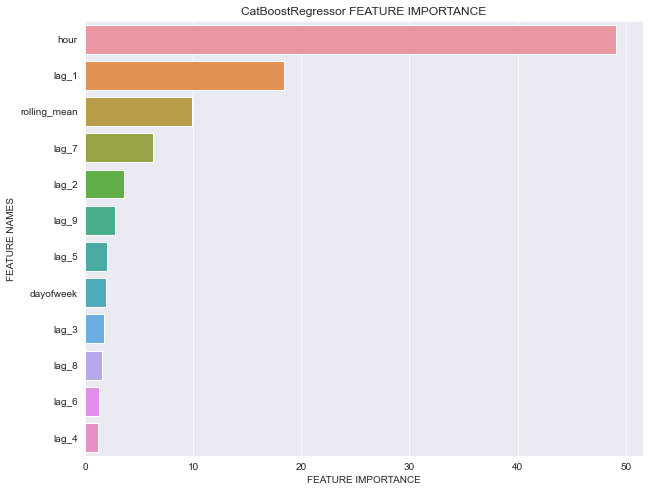

In [26]:
# Посмотрим feature importance

plot_feature_importance(model.feature_importances_,X_test.columns,'CatBoostRegressor ')

На данной диаграмме видно, какие признаки внесли наибольший вклад в модель, немного неожиданно, что 7 лаг внес довольно весомый вклад.

<AxesSubplot:xlabel='datetime'>

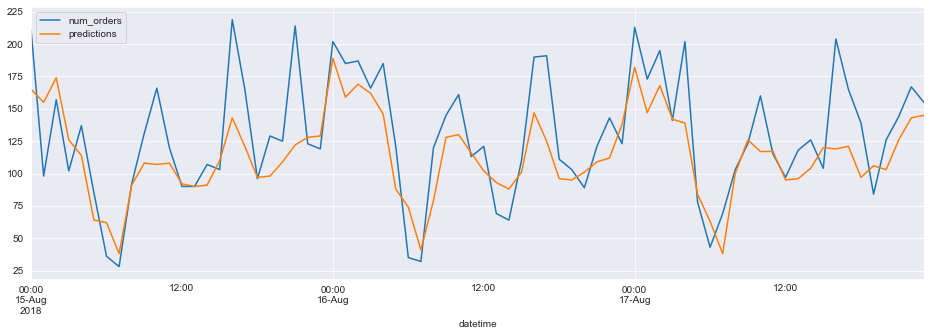

In [27]:
# Выведем на графике реальное количество заказов в день и предсказанное нашей моделью

graph = y_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = X_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

**Итак, наша модель неплохо предсказывает реальные заказы, значение RMSE 45,8. Более детальный тюнинг моделей улучшил бы результаты, но пожелания заказчика вывполнены!**